# Credir card - Notebook d'exploration des données

## Init application

- Variable qui contient le dossier du projet

In [37]:
APPLICATION_HOME = "/home/akkodis-nizar_el-maghroudi/projetecole"

- Chemin vers le fichier yaml contenant les paramétrages

In [38]:
import yaml
yamlFile = f"{APPLICATION_HOME}/conf/application.yaml"
with open(yamlFile, "r") as f:
    cfg = yaml.safe_load(f)

- Import des librairies

In [39]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- Options d'affichage

In [40]:
pd.options.display.max_columns = 100# Max number of columns to show
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 3000#Max size of a column

- Variables globales

In [41]:
INPUT = cfg.get("DATA")["input"].replace("{APPLICATION_HOME}", APPLICATION_HOME)
OUTPUT = cfg.get("DATA")["output"].replace("{APPLICATION_HOME}", APPLICATION_HOME)

- Ensemble de fonctions utiles

In [42]:

def plotSub(df, lVariables, row, col, width, height):
    """
    Fonction pour afficher des sous-graphiques pour chaque variable.
    :param df: DataFrame avec une colonne 'dates' + colonnes de données
    :param lVariables: liste de variables à tracer (ex: ["V1", ..., "V28"])
    :param row: nombre de lignes
    :param col: nombre de colonnes
    :param width: largeur totale de la figure
    :param height: hauteur totale de la figure
    """
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(width, height))

    # Si on n’a qu’un seul axe, le transformer en liste pour uniformiser
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(len(axes)):
        if i < len(lVariables):
            var = lVariables[i]
            axes[i].plot(df['dates'], df[var])
            axes[i].set_title(f"Signal de {var}", fontsize=10)
            axes[i].set_xlabel("Date")
            axes[i].set_ylabel("Valeur")
        else:
            axes[i].axis("off")  # Cache les sous-graphiques vides

    plt.tight_layout()
    plt.show()


In [43]:
def plotScatterByClass(df, lVariables, class_col, height_per_plot=3):
    """
    Pour chaque variable de lVariables, trace un scatter plot en fonction de class_col,
    en empilant tous les plots dans une seule colonne verticale.
    
    :param df: DataFrame pandas
    :param lVariables: liste de variables à tracer (colonnes numériques)
    :param class_col: nom de la colonne catégorielle (axe x)
    :param height_per_plot: hauteur d'un plot (en pouces)
    """
    n = len(lVariables)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, height_per_plot * n), sharex=True)

    # Si une seule variable, axes n'est pas tableau, on le transforme en liste
    if n == 1:
        axes = [axes]

    for ax, var in zip(axes, lVariables):
        sns.scatterplot(data=df, x=var, y=class_col, ax=ax, s=10)
        sns.regplot(data=df, x=class_col, y=var, ax=ax, ci=None, scatter=False, 
                    line_kws={"color": "red", "linewidth": 1})
        ax.set_ylabel(var)
        ax.set_xlabel('' if ax != axes[-1] else class_col)  # xlabel seulement sur dernier plot
        ax.set_title(f"{var} en fonction de {class_col}", fontsize=10)

    plt.tight_layout()
    plt.show()


In [44]:
def plotBox(df, lVariables, row, col, width, height):
    """
    Fonction qui trace des boxplots horizontaux.

    :param df: DataFrame pandas contenant les données à représenter
    :param group: nom de la colonne utilisée pour le regroupement (catégorie ou groupe)
    :param lVariables: liste des noms de colonnes à utiliser pour les boxplots
    :param row: entier indiquant le nombre de lignes de graphiques
    :param col: entier indiquant le nombre de graphiques par ligne
    :param width: entier représentant la largeur de la figure
    :param height: entier représentant la hauteur de la figure
    """

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(width, height))
    red_circle = dict(markerfacecolor="r", marker="D", markeredgecolor="none", markersize=3)
    i = 0 ;
    for row in ax:
        for col in row:
            y = lVariables[i]
            col.boxplot(df[y], vert=False, flierprops=red_circle) 
            col.set(xlabel="Valeur")
            col.set_title(f"Boxlot de {y.upper()}", fontsize=14, fontweight="bold")
#            col.label_outer()
            i=i+1
    fig.tight_layout()
    plt.show()

In [45]:
def remove_outliers(df, columns, method='iqr', threshold=2.5):
    """
    Supprime les lignes avec des valeurs aberrantes dans les colonnes spécifiées,
    uniquement pour les observations où Class == 0.

    :param df: DataFrame pandas
    :param columns: liste des colonnes à traiter
    :param method: méthode pour détecter les outliers ('iqr' ou 'zscore')
    :param threshold: seuil (1.5 pour IQR, 3 pour z-score en général)
    :return: DataFrame sans outliers pour Class == 0, inchangé pour Class == 1
    """
    # Commentaire expliquant le choix
    # On supprime les outliers uniquement pour Class == 0 car il y a trop peu de valeurs pour Class == 1
    # Cela évite d'éliminer des données rares et potentiellement importantes pour la classe minoritaire.

    df_clean = df.copy()

    # Séparer les deux sous-ensembles
    df_class0 = df_clean[df_clean['Class'] == 0]
    df_class1 = df_clean[df_clean['Class'] == 1]

    for col in columns:
        if col not in df_class0.columns:
            print(f"⚠️ Colonne '{col}' introuvable.")
            continue

        if method == 'iqr':
            Q1 = df_class0[col].quantile(0.25)
            Q3 = df_class0[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            condition = df_class0[col].between(lower_bound, upper_bound)
        elif method == 'zscore':
            mean = df_class0[col].mean()
            std = df_class0[col].std()
            condition = ((df_class0[col] - mean) / std).abs() <= threshold
        else:
            raise ValueError("Méthode inconnue. Utilise 'iqr' ou 'zscore'.")

        df_class0 = df_class0[condition]

    # Recombine les données nettoyées de Class==0 avec celles de Class==1 non modifiées
    df_clean = pd.concat([df_class0, df_class1], axis=0)

    # On remet l'ordre initial si nécessaire
    df_clean = df_clean.sort_index()

    return df_clean


In [46]:
def corrHeatmap(df, target_col, cols=None, threshold=0.3):
    """
    Affiche une heatmap des corrélations significatives avec une colonne cible.

    :param df: DataFrame pandas
    :param target_col: Nom (str) de la colonne cible pour la corrélation
    :param cols: Liste optionnelle des colonnes à comparer
    :param threshold: Seuil absolu minimum de corrélation à afficher (ex: 0.3)
    :return: Liste des noms de colonnes avec corrélation absolue >= threshold
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    if cols is None:
        cols = df.select_dtypes(include='number').columns.drop(target_col, errors='ignore')

    corr_series = df[cols].corrwith(df[target_col])
    filtered_corr = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

    if filtered_corr.empty:
        print(f"Aucune corrélation au-dessus de {threshold}")
        return []

    plt.figure(figsize=(6, len(filtered_corr) * 0.4))
    sns.heatmap(filtered_corr.to_frame(name=f"Corr. avec {target_col}"), 
                annot=True, cmap='coolwarm', center=0, cbar=True)
    plt.title(f"Corrélations fortes avec {target_col} (>|{threshold}|)")
    plt.tight_layout()
    plt.show()
    
    return list(filtered_corr.index)


In [47]:
def compareHistoPlot(df, name, bin=5, n=1000):
    l = df[name].dropna()
    
    # Si colonne de type datetime
    if np.issubdtype(l.dtype, np.datetime64):
        min_date = l.min()
        max_date = l.max()
        
        # Créer des bins réguliers sur l’intervalle de dates
        xbins = pd.date_range(start=min_date, end=max_date, periods=n)
        
        plt.figure(figsize=(8,4))
        plt.hist(l, bins=xbins, histtype='step', label=name)
        plt.ylabel("Nombre par intervalle")
        plt.title(f"Histogramme de {name}")
        plt.legend()
        plt.show()
        
    else:
        min_val = l.min()
        max_val = l.max()
        
        xbins = np.arange(min_val, max_val + bin, bin)
        
        plt.figure(figsize=(8,4))
        plt.hist(l, bins=xbins, histtype='step', label=name)
        plt.ylabel("Nombre par intervalle")
        plt.title(f"Histogramme de {name}")
        plt.legend()
        plt.show()


In [48]:
import pandas as pd
import numpy as np
import plotly.express as px


def plot_value_frequencies_plotly(df, column=None, bin_width=2):
    """
    Version interactive (Plotly) des fréquences de valeurs
    - Groupement automatique en bins si numérique continue

    :param df: pandas DataFrame
    :param column: colonne ciblée (ou None pour toutes)
    :param bin_width: taille des intervalles si numérique
    """
    columns = [column] if column else df.columns

    for col in columns:
        if col not in df.columns:
            print(f"⚠️ Colonne '{col}' introuvable.")
            continue

        series = df[col].dropna()

        if np.issubdtype(series.dtype, np.number) and series.nunique() > 30:
            # Histogramme numérique groupé par intervalles
            fig = px.histogram(df, x=col, nbins=int((series.max() - series.min()) / bin_width),
                               title=f"Histogramme groupé de '{col}'",
                               labels={col: col}, template="plotly_white")
        else:
            # Comptage des valeurs uniques
            value_counts = series.value_counts().reset_index()
            value_counts.columns = [col, 'Count']
            fig = px.bar(value_counts, x=col, y='Count',
                         title=f"Fréquence des valeurs uniques de '{col}'",
                         labels={col: "Valeur", 'Count': "Nombre"}, template="plotly_white")

        fig.update_layout(xaxis_tickangle=45)
        fig.show()


## A / Exploring the dataset

#### 1. Lecture des données

In [49]:
csvFile = f'{APPLICATION_HOME}/credit-card-clients/UCl_credits_card.csv'

encodage = "UTF-8"#ISO-8859-1
sep = ","

dataset = pd.read_csv(csvFile, sep=",", encoding=encodage)

In [50]:
# Afficher toutes les colonnes sans coupure
pd.set_option('display.max_columns', None)

# Afficher toute la largeur sans coupure
pd.set_option('display.width', None)

# Facultatif : augmenter la largeur de colonne affichée
pd.set_option('display.max_colwidth', None)

dataset.head(10)

dates   id        V1        V2        V3        V4        V5  \
0  2008-08-02 22:21:39  0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321   
1  2008-02-02 01:40:48  0.0  1.191857  0.266151  0.166480  0.448154  0.060018   
2  2007-06-23 08:49:12  1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198   
3  2008-06-13 13:12:53  1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309   
4  2007-11-25 12:29:10  2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193   
5  2007-06-29 09:45:16  2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987   
6  2008-06-21 14:55:35  4.0  1.229658  0.141004  0.045371  1.202613  0.191881   
7  2007-07-25 16:32:11  7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934   
8  2008-01-28 04:17:08  7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599   
9  2007-08-31 02:45:23  9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361   

         V6        V7        V8        V9       V10       V11       V12  \
0  0.462388  0.239599  0.098698  0.363787  0.090794 -0.551600 -0.617801   
1 -0.082361 -0.078803  0.085102 -0.255425 -0.166974  1.612727  1.065235   
2  1.800499  0.791461  0.247676 -1.514654  0.207643  0.624501  0.066084   
3  1.247203  0.237609  0.377436 -1.387024 -0.054952 -0.226487  0.178228   
4  0.095921  0.592941 -0.270533  0.817739  0.753074 -0.822843  0.538196   
5 -0.029728  0.476201  0.260314 -0.568671 -0.371407  1.341262  0.359894   
6  0.272708 -0.005159  0.081213  0.464960 -0.099254 -1.416907 -0.153826   
7  0.428118  1.120631 -3.807864  0.615375  1.249376 -0.619468  0.291474   
8  3.721818  0.370145  0.851084 -0.392048 -0.410430 -0.705117 -0.110452   
9 -0.246761  0.651583  0.069539 -0.736727 -0.366846  1.017614  0.836390   

        V13       V14       V15       V16       V17       V18       V19  \
0 -0.991390 -0.311169  1.468177 -0.470401  0.207971  0.025791  0.403993   
1  0.489095 -0.143772  0.635558  0.463917 -0.114805 -0.183361 -0.145783   
2  0.717293 -0.165946  2.345865 -2.890083  1.109969 -0.121359 -2.261857   
3  0.507757 -0.287924 -0.631418 -1.059647 -0.684093  1.965775 -1.232622   
4  1.345852 -1.119670  0.175121 -0.451449 -0.237033 -0.038195  0.803487   
5 -0.358091 -0.137134  0.517617  0.401726 -0.058133  0.068653 -0.033194   
6 -0.751063  0.167372  0.050144 -0.443587  0.002821 -0.611987 -0.045575   
7  1.757964 -1.323865  0.686133 -0.076127 -1.222127 -0.358222  0.324505   
8 -0.286254  0.074355 -0.328783 -0.210077 -0.499768  0.118765  0.570328   
9  1.006844 -0.443523  0.150219  0.739453 -0.540980  0.476677  0.451773   

        V20       V21       V22       V23       V24       V25       V26  \
0  0.251412 -0.018307  0.277838 -0.110474  0.066928  0.128539 -0.189115   
1 -0.069083 -0.225775 -0.638672  0.101288 -0.339846  0.167170  0.125895   
2  0.524980  0.247998  0.771679  0.909412 -0.689281 -0.327642 -0.139097   
3 -0.208038 -0.108300  0.005274 -0.190321 -1.175575  0.647376 -0.221929   
4  0.408542 -0.009431  0.798278 -0.137458  0.141267 -0.206010  0.502292   
5  0.084968 -0.208254 -0.559825 -0.026398 -0.371427 -0.232794  0.105915   
6 -0.219633 -0.167716 -0.270710 -0.154104 -0.780055  0.750137 -0.257237   
7 -0.156742  1.943465 -1.015455  0.057504 -0.649709 -0.415267 -0.051634   
8  0.052736 -0.073425 -0.268092 -0.204233  1.011592  0.373205 -0.384157   
9  0.203711 -0.246914 -0.633753 -0.120794 -0.385050 -0.069733  0.094199   

        V27       V28  Amount  Class  
0  0.133558 -0.021053  149.62      0  
1 -0.008983  0.014724    2.69      0  
2 -0.055353 -0.059752  378.66      0  
3  0.062723  0.061458  123.50      0  
4  0.219422  0.215153   69.99      0  
5  0.253844  0.081080    3.67      0  
6  0.034507  0.005168    4.99      0  
7 -1.206921 -1.085339   40.80      0  
8  0.011747  0.142404   93.20      0  
9  0.246219  0.083076    3.68      0

In [51]:
dataset.dtypes

dates      object
id        float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

#### 2. Modification du type des variables

- la variable *dates* sera convertie en datetime et utilisée pour trier le dataset

In [52]:
dataset["dates"]=pd.to_datetime(dataset["dates"], format="%Y-%m-%d %H:%M:%S")
dataset = dataset.sort_values(by=["dates"], ascending=True)

In [53]:
dataset.dtypes

dates     datetime64[ns]
id               float64
V1               float64
V2               float64
V3               float64
V4               float64
V5               float64
V6               float64
V7               float64
V8               float64
V9               float64
V10              float64
V11              float64
V12              float64
V13              float64
V14              float64
V15              float64
V16              float64
V17              float64
V18              float64
V19              float64
V20              float64
V21              float64
V22              float64
V23              float64
V24              float64
V25              float64
V26              float64
V27              float64
V28              float64
Amount           float64
Class              int64
dtype: object

#### 3. Définition de la période de l'étude

- Visualisation de l'évolution des **paramètres** et des **facteurs variables** dans le temps

Le but est de voir s'il y a une période ou il y a pas trop de données et aussi voir les ordres de grandeurs

In [54]:
lParameters = [
    "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10",
    "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20",
    "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28"
]


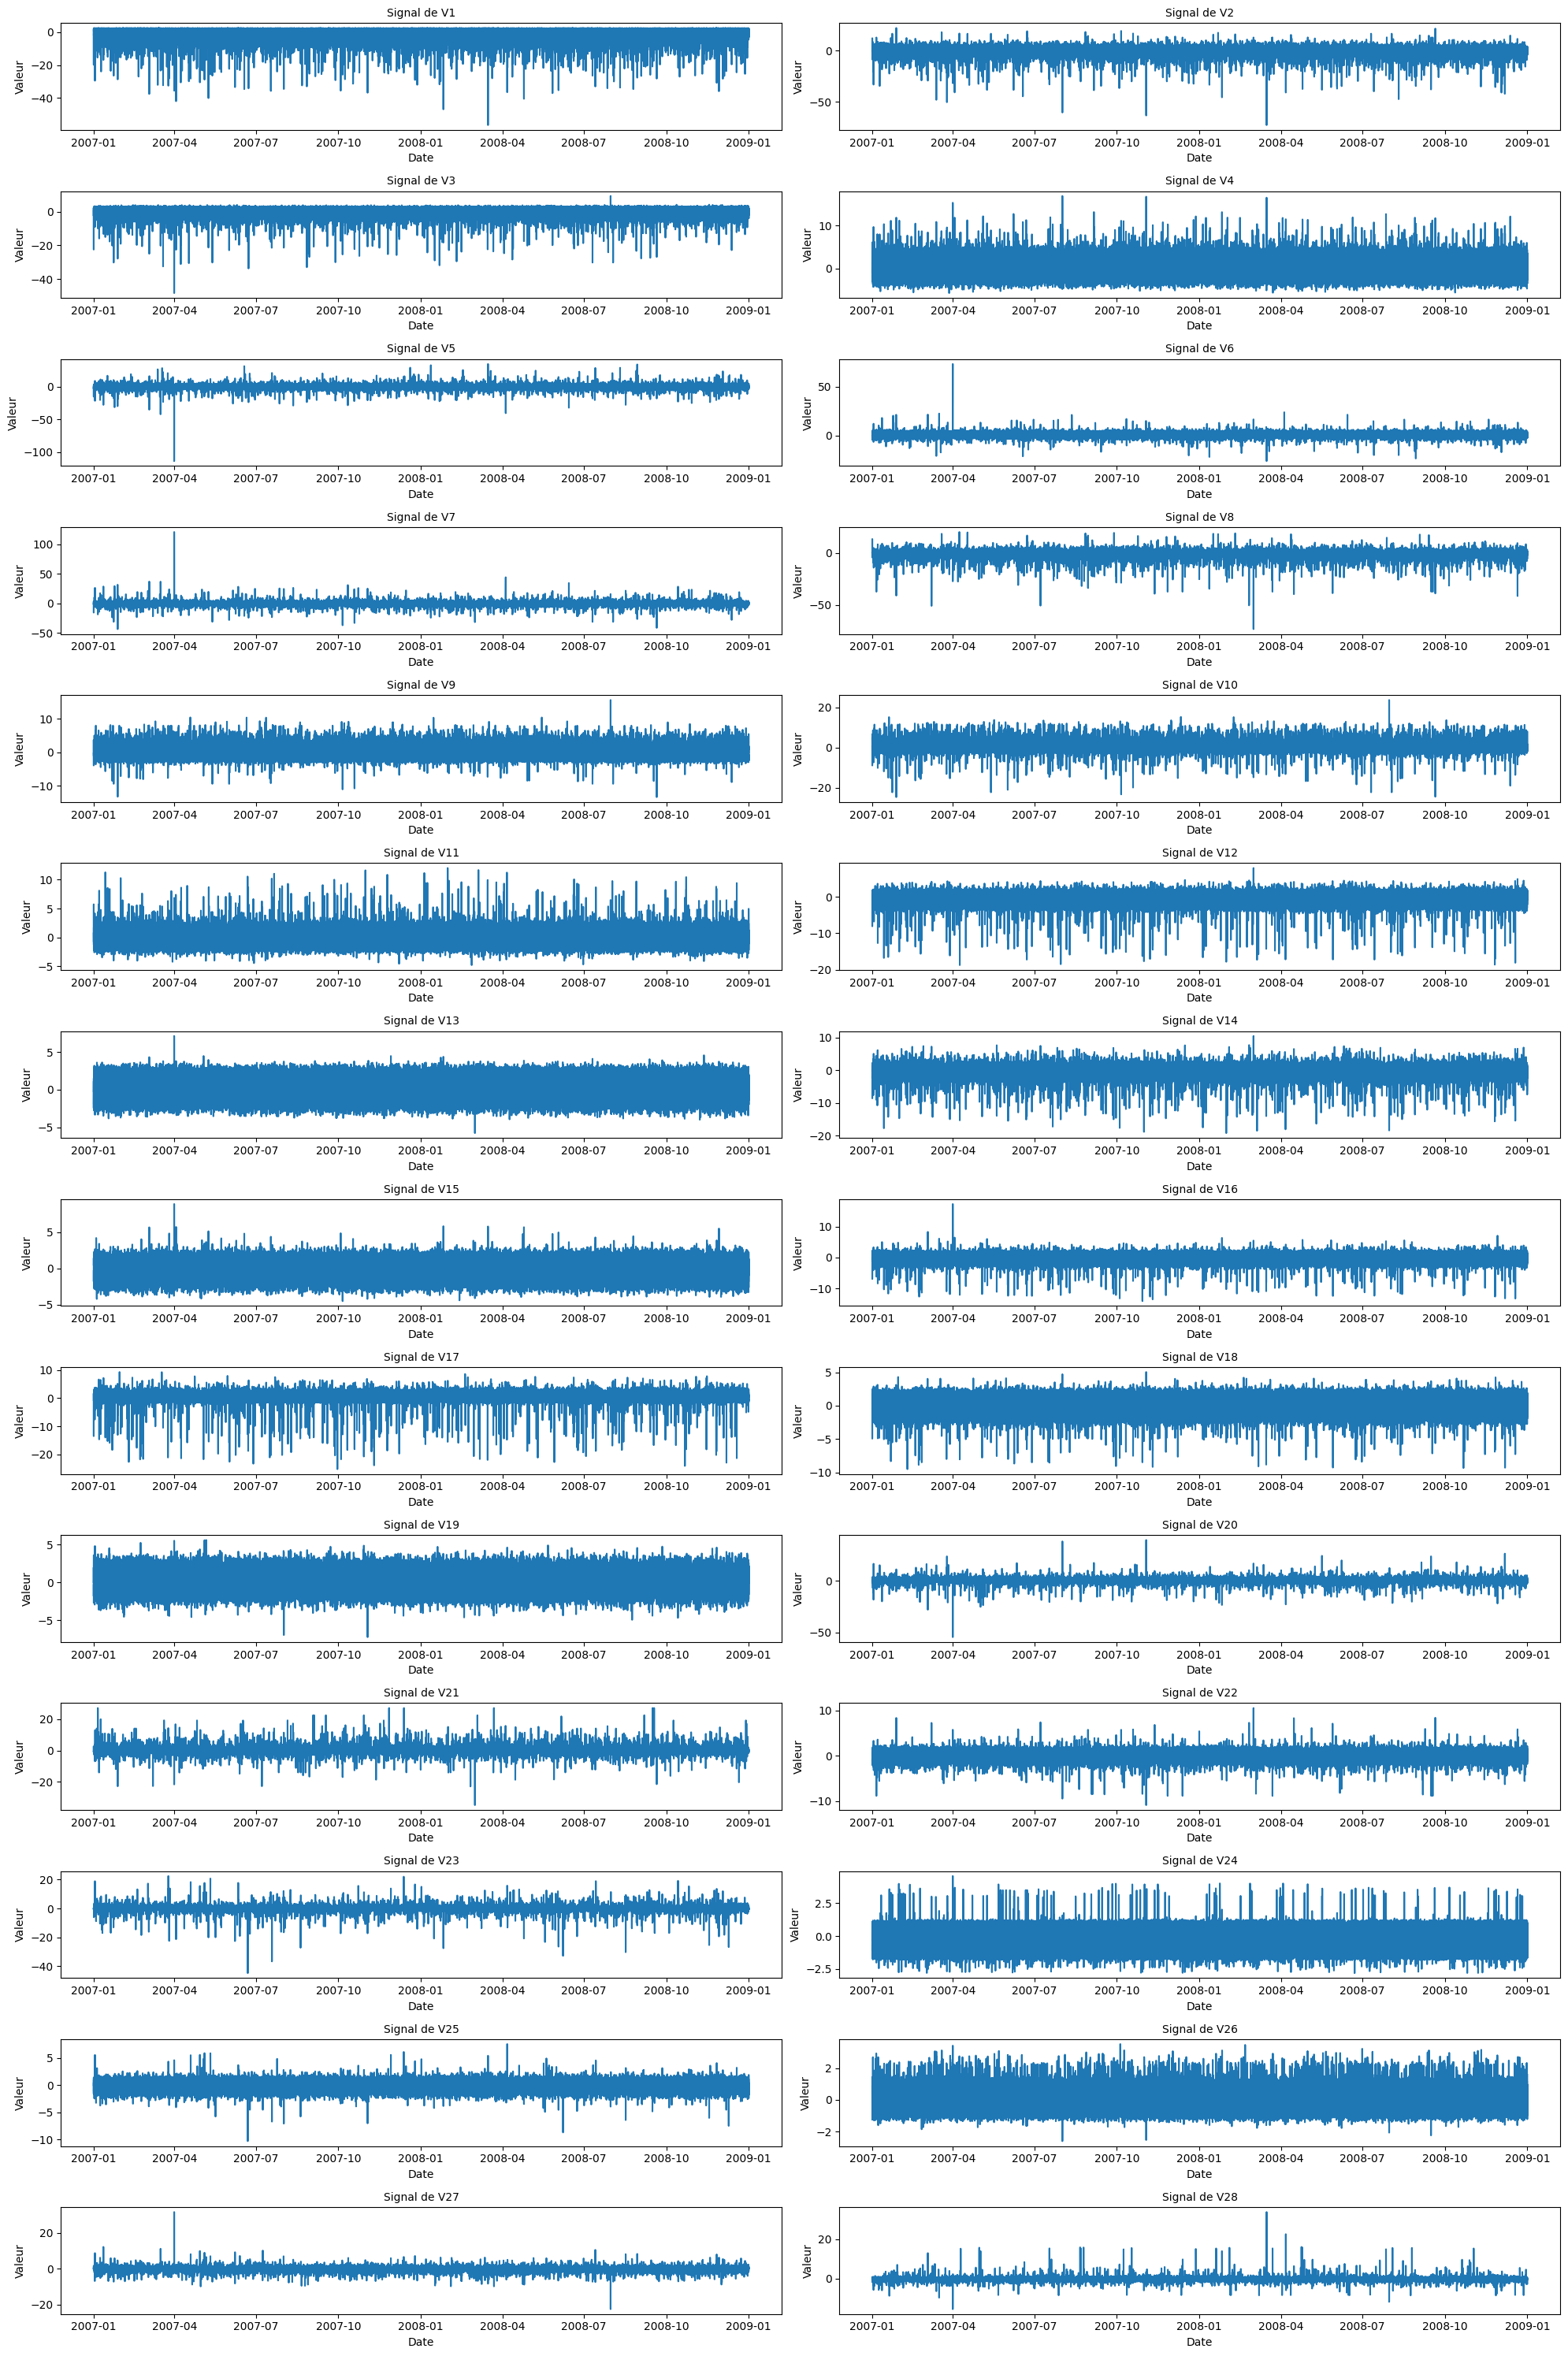

In [55]:
plotSub(dataset, lParameters, row=14, col=2, width=20, height=30)


- On observe la présence de valeurs aberrantes qu’il conviendra de traiter. En ce qui concerne la période d’étude, la quantité de données est suffisante et ne présente pas de creux significatif.

#### 4. Choix des colonnes

- Les données contiennent des variables de type caractère



In [56]:
data=dataset

In [57]:
dfNonNumValues = data.select_dtypes(include="object").nunique().sort_values()
dfNonNumValues

Series([], dtype: float64)

- Et des variables numériques

In [58]:
dfNumValues = data.select_dtypes(include="number").nunique().sort_values()
dfNumValues

Class          2
Amount     32767
id        124592
V1        275663
V4        275663
V5        275663
V2        275663
V3        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V6        275663
V7        275663
V15       275663
V14       275663
V16       275663
V17       275663
V20       275663
V21       275663
V18       275663
V19       275663
V23       275663
V22       275663
V24       275663
V25       275663
V27       275663
V26       275663
V28       275663
dtype: int64

In [59]:
selectedCol = data.columns

In [60]:
data = data[selectedCol].drop_duplicates()
print(f"\trows: {data.shape[0]}, columns: {len(data.columns)}") # Taille du dataframe
data.head(5)

	rows: 284807, columns: 32


dates        id        V1        V2        V3        V4  \
54160  2007-01-01 00:03:44   46312.0  1.268712 -0.770499  0.585889 -0.814853   
33866  2007-01-01 00:11:06   37415.0  1.121711  0.162140 -0.051158  1.225896   
101438 2007-01-01 00:11:34   67834.0  0.348415  0.757397  1.118159  0.799891   
170994 2007-01-01 00:15:48  120447.0 -4.863909  4.305565 -2.460454 -1.827332   
198951 2007-01-01 00:18:06  132726.0  2.010561 -0.959160 -1.385803 -0.998450   

              V5        V6        V7        V8        V9       V10       V11  \
54160  -1.056622 -0.049472 -0.828265  0.047259 -0.872588  0.770514  0.687212   
33866  -0.086933 -0.696453  0.342519 -0.041241  0.036785  0.067175 -0.493512   
101438  0.169821 -0.195680  0.532320 -0.225032 -0.621191  0.508475  1.195480   
170994  0.926029  0.363901  0.928486 -0.114347  3.659426  5.195675  0.475273   
198951 -0.396678 -0.703357 -0.239847 -0.255430 -0.844283  0.902987  0.929483   

             V12       V13       V14       V15       V16       V17       V18  \
54160   0.635290  1.013683 -0.067586  0.516323 -0.510193 -0.734337  1.733943   
33866  -0.929493 -2.466983  1.077115  1.194994 -0.226205  0.081176 -0.824615   
101438  0.606912  0.472978  0.227094  0.902347 -0.228322 -0.365158  0.404685   
170994 -0.282251 -0.861551 -2.450240  0.919923 -1.314393  1.169091 -1.870238   
198951  0.507323  0.842918  0.055150 -0.622918  1.112031 -0.131026 -1.374417   

             V19       V20       V21       V22       V23       V24       V25  \
54160  -0.353514 -0.288418 -0.430103 -0.900940  0.054887 -0.329283 -0.029904   
33866  -0.506027 -0.246856 -0.303496 -1.079730  0.109092 -0.031283  0.330580   
101438  1.979196  0.205937 -0.077171  0.022606  0.181109  0.011013 -1.603859   
170994 -1.803533  1.833490 -0.499076 -0.461948  0.306644 -0.450089  0.348479   
198951  1.082027  0.206692  0.036650 -0.121652  0.152727 -0.459453 -0.212516   

             V26       V27       V28  Amount  Class  
54160   0.874340 -0.040868  0.014407   58.84      0  
33866  -0.614003 -0.011922  0.019631   49.80      0  
101438  0.080414  0.092227  0.020359    1.29      0  
170994  0.321646  0.442061  0.872154    2.48      0  
198951 -0.428540 -0.047692 -0.053563  105.00      0

#### 5. Analyse des points aberrants

#### 5.1) Graphiques des distributions à l'aide des boxplots

- Nous constatons qu'il y a de nombreux points aberrants. Le choix de la stratégie à adopter pour les éliminer peut impacter le nombre de points disponibles,sur les box qui sont tracés par la fonction plotBox , on trouve ci dessous plusieurs points aberrants

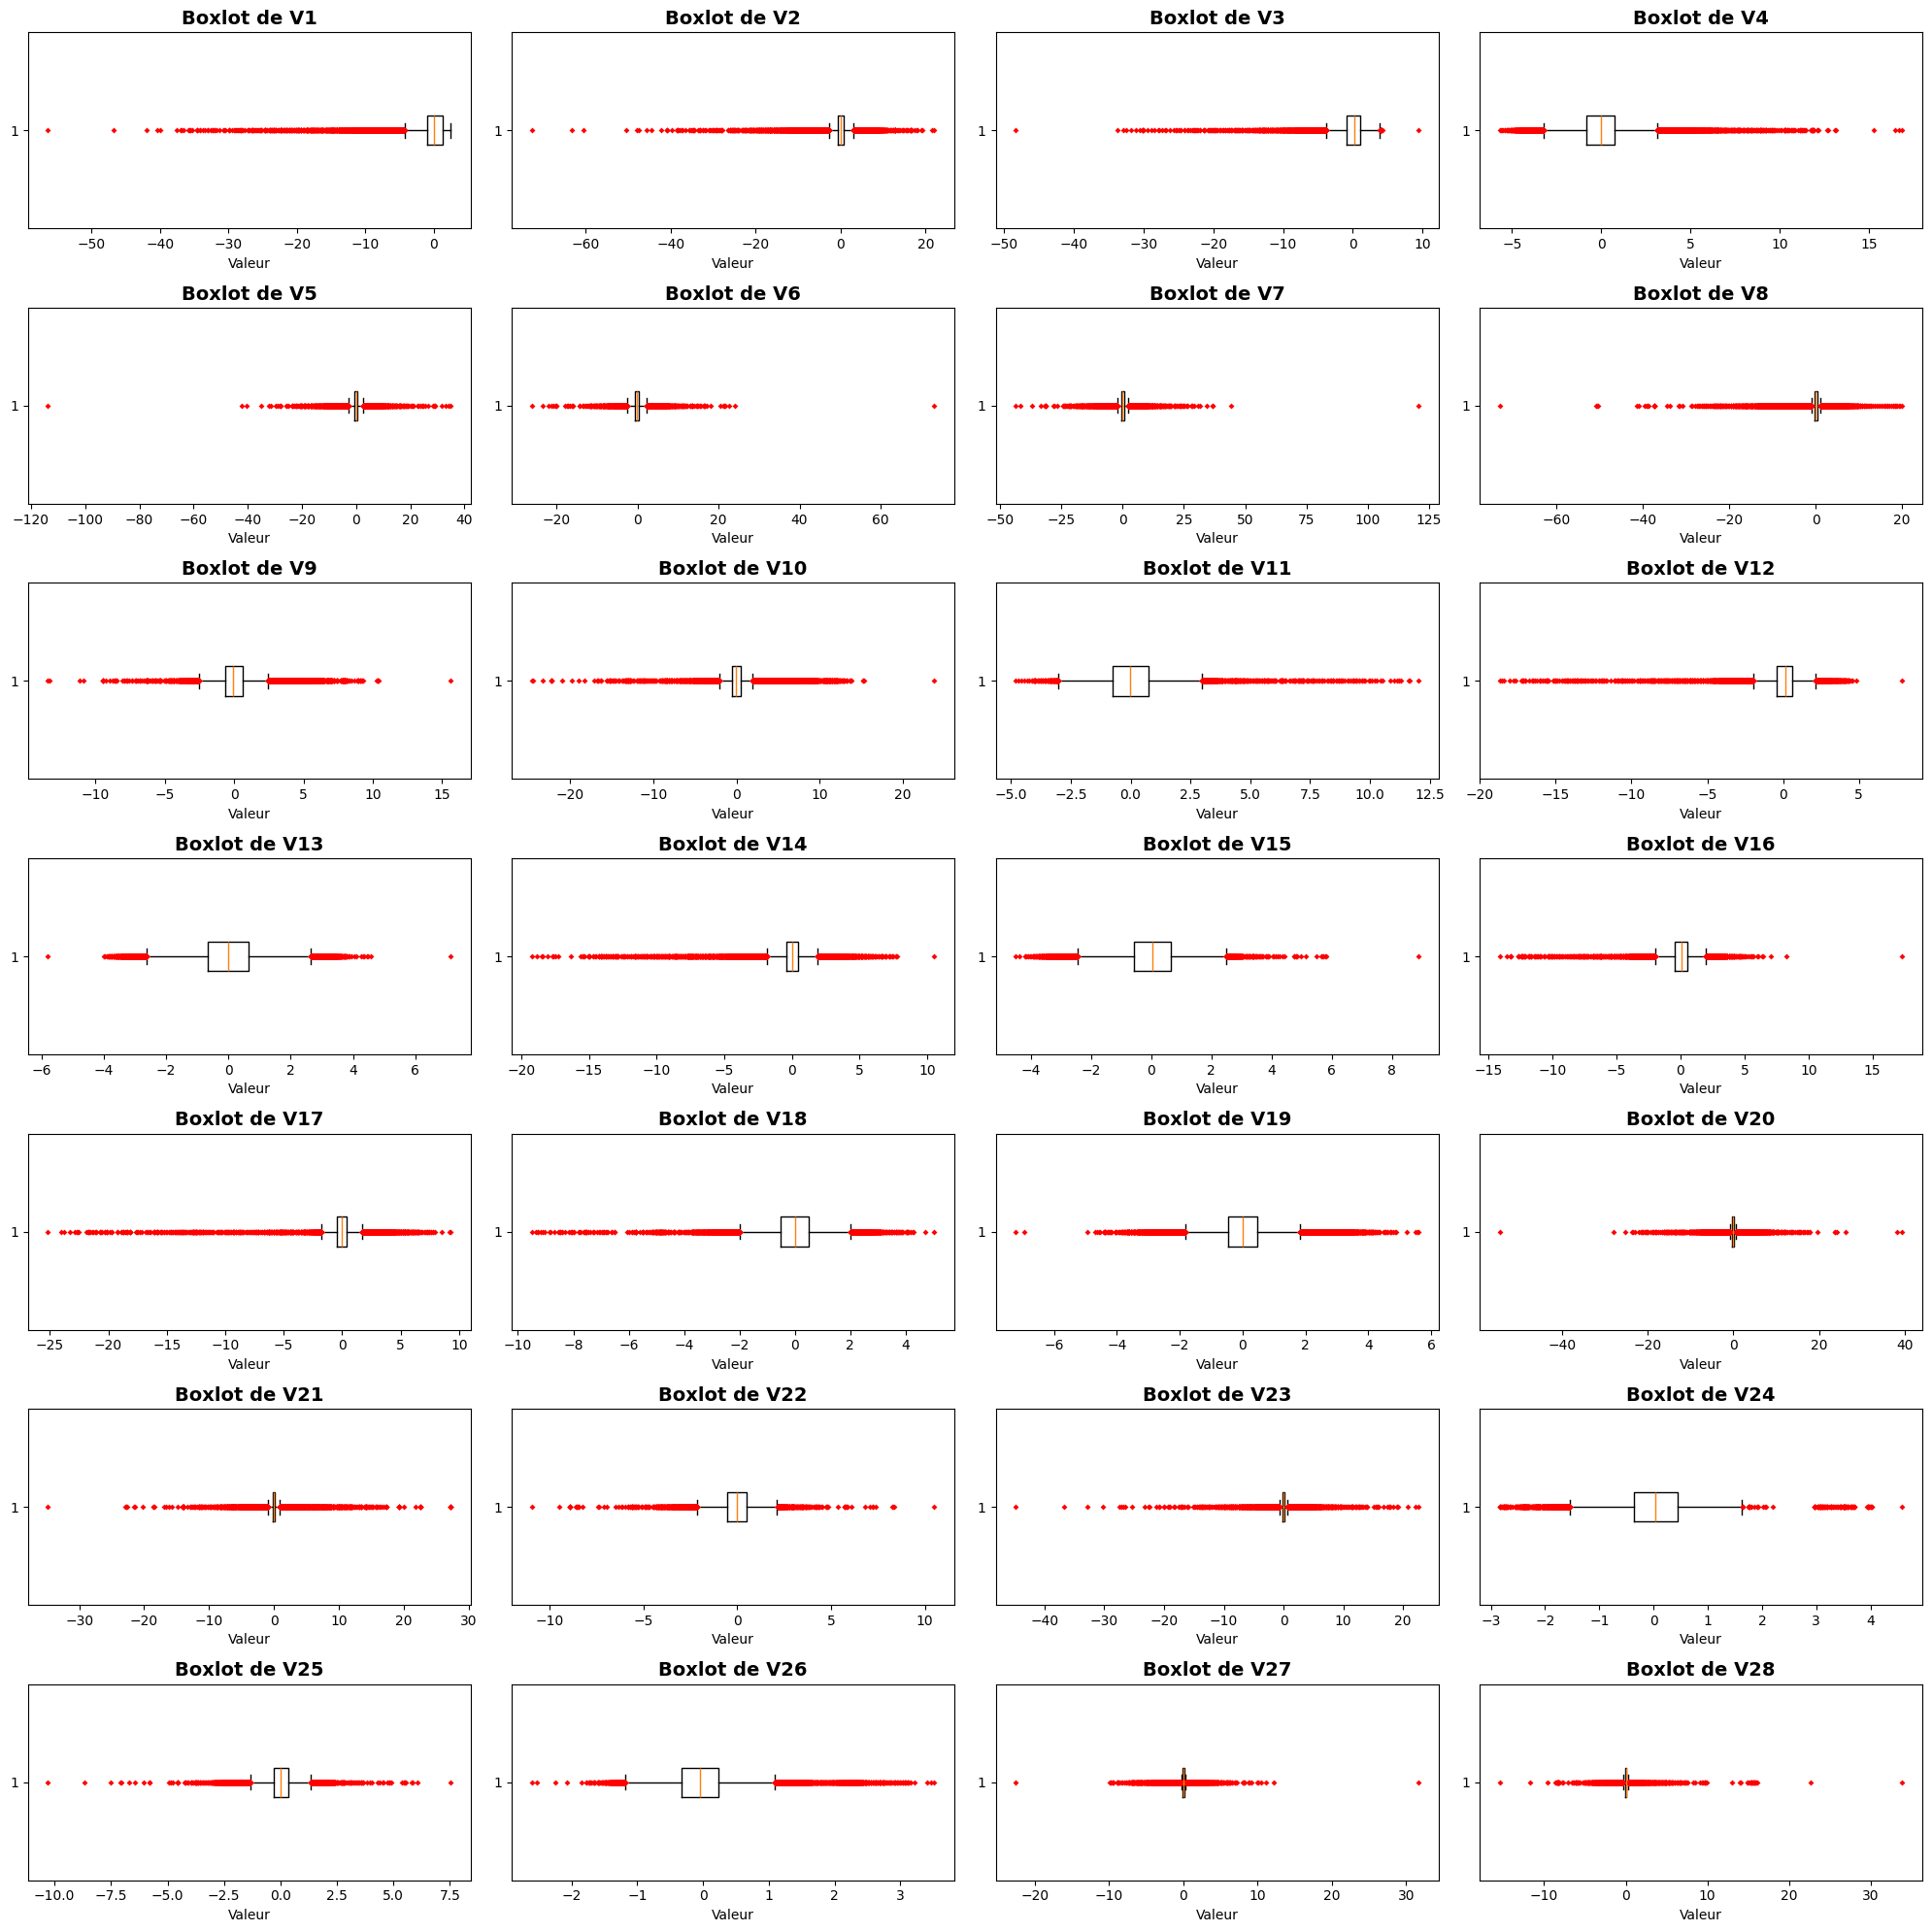

In [61]:
plotBox(dataset,lParameters, row=7, col=4, width=20, height=20)

#### 5.2) Nettoyage des données

- Nous identifions les lignes des points aberrants en créant de nouvelles colonnes booléennes pour ensuite filtrer le dataframe en utilisant ces colonnes, pour traiter donc les points aberrants on utilise la fonction "remove_outliers"

In [62]:
plot_value_frequencies_plotly(dataset, column="Class", bin_width=2)

> **Remarque :**

> La colonne Class est la colonne qui nous interesse car c'est elle qui montre si l'opération est une fraude bancaire ou non.

> Comme on le voit sur cet histogramme, la classe **1** ne contient que **492** observations dans le jeu de données complet.  
> Par conséquent, il n’est pas pertinent de supprimer les outliers pour la classe 1, car cela réduirait trop le nombre d’échantillons disponibles.  
> La suppression des valeurs aberrantes est donc appliquée uniquement pour la classe **0**, où le volume de données est suffisant pour garantir la robustesse de l’analyse.


In [63]:
dfOutliers = remove_outliers(dataset,lParameters, method="iqr", threshold=1.5)


In [64]:
dataset.shape

(284807, 32)

In [65]:
dfOutliers.shape
## on voit bien que le nombre de lignes a diminué après avoir supprimé les valeurs aberrantoes

(121002, 32)

- Quelques statistiques de poids de ces valeurs aberrants dans la population totale

In [66]:
l = [col for col in list(dataset.columns) if "outliers" in col]
dfGraph = dfOutliers[l]
dfGraph.head()

N = dfOutliers.shape[0]
lPctOutliers = []
for col in dfOutliers.columns:
    dfTrue = dfOutliers[dfOutliers[col]==True]
    pctTrue = np.round(100*dfTrue.shape[0]/N, 4)
    lPctOutliers.append(pctTrue)

In [67]:
dfGraph.columns

Index([], dtype='object')

In [68]:
dfGraph.shape

(121002, 0)

In [69]:
 len(list(dfGraph.columns))


0

- Nous éliminons du dataset ces points. Il est possible de modifier le niveau de filtrage de ces points en ajustant le paramètre threshold dans la fonction remove_outliers (1.5,2.5,2 ...)

In [70]:
l = [col for col in dfOutliers.columns if "outliers" in col]
for i in range(len(l)):
    col = l[i]
    dfOutliers = dfOutliers[dfOutliers[col]==False]

#### 5.2) Données après suppression des valeurs aberrantes

> Après la suppression des points aberrants , nous remarquons que la fréqence de la class 0 a diminué et la fréquence de la classe 1 n'a pas changé

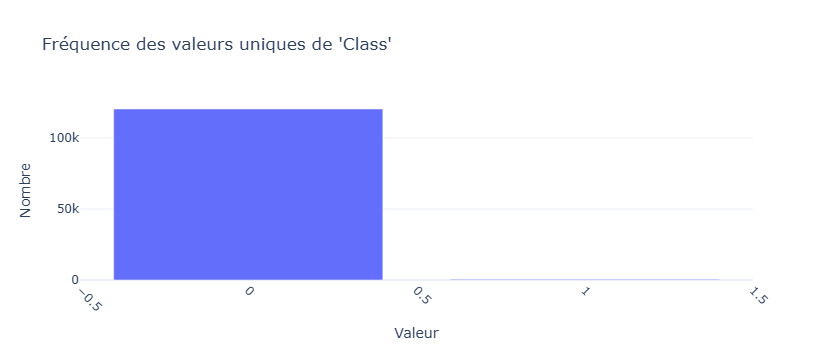

In [71]:
plot_value_frequencies_plotly(dfOutliers, column="Class", bin_width=2)

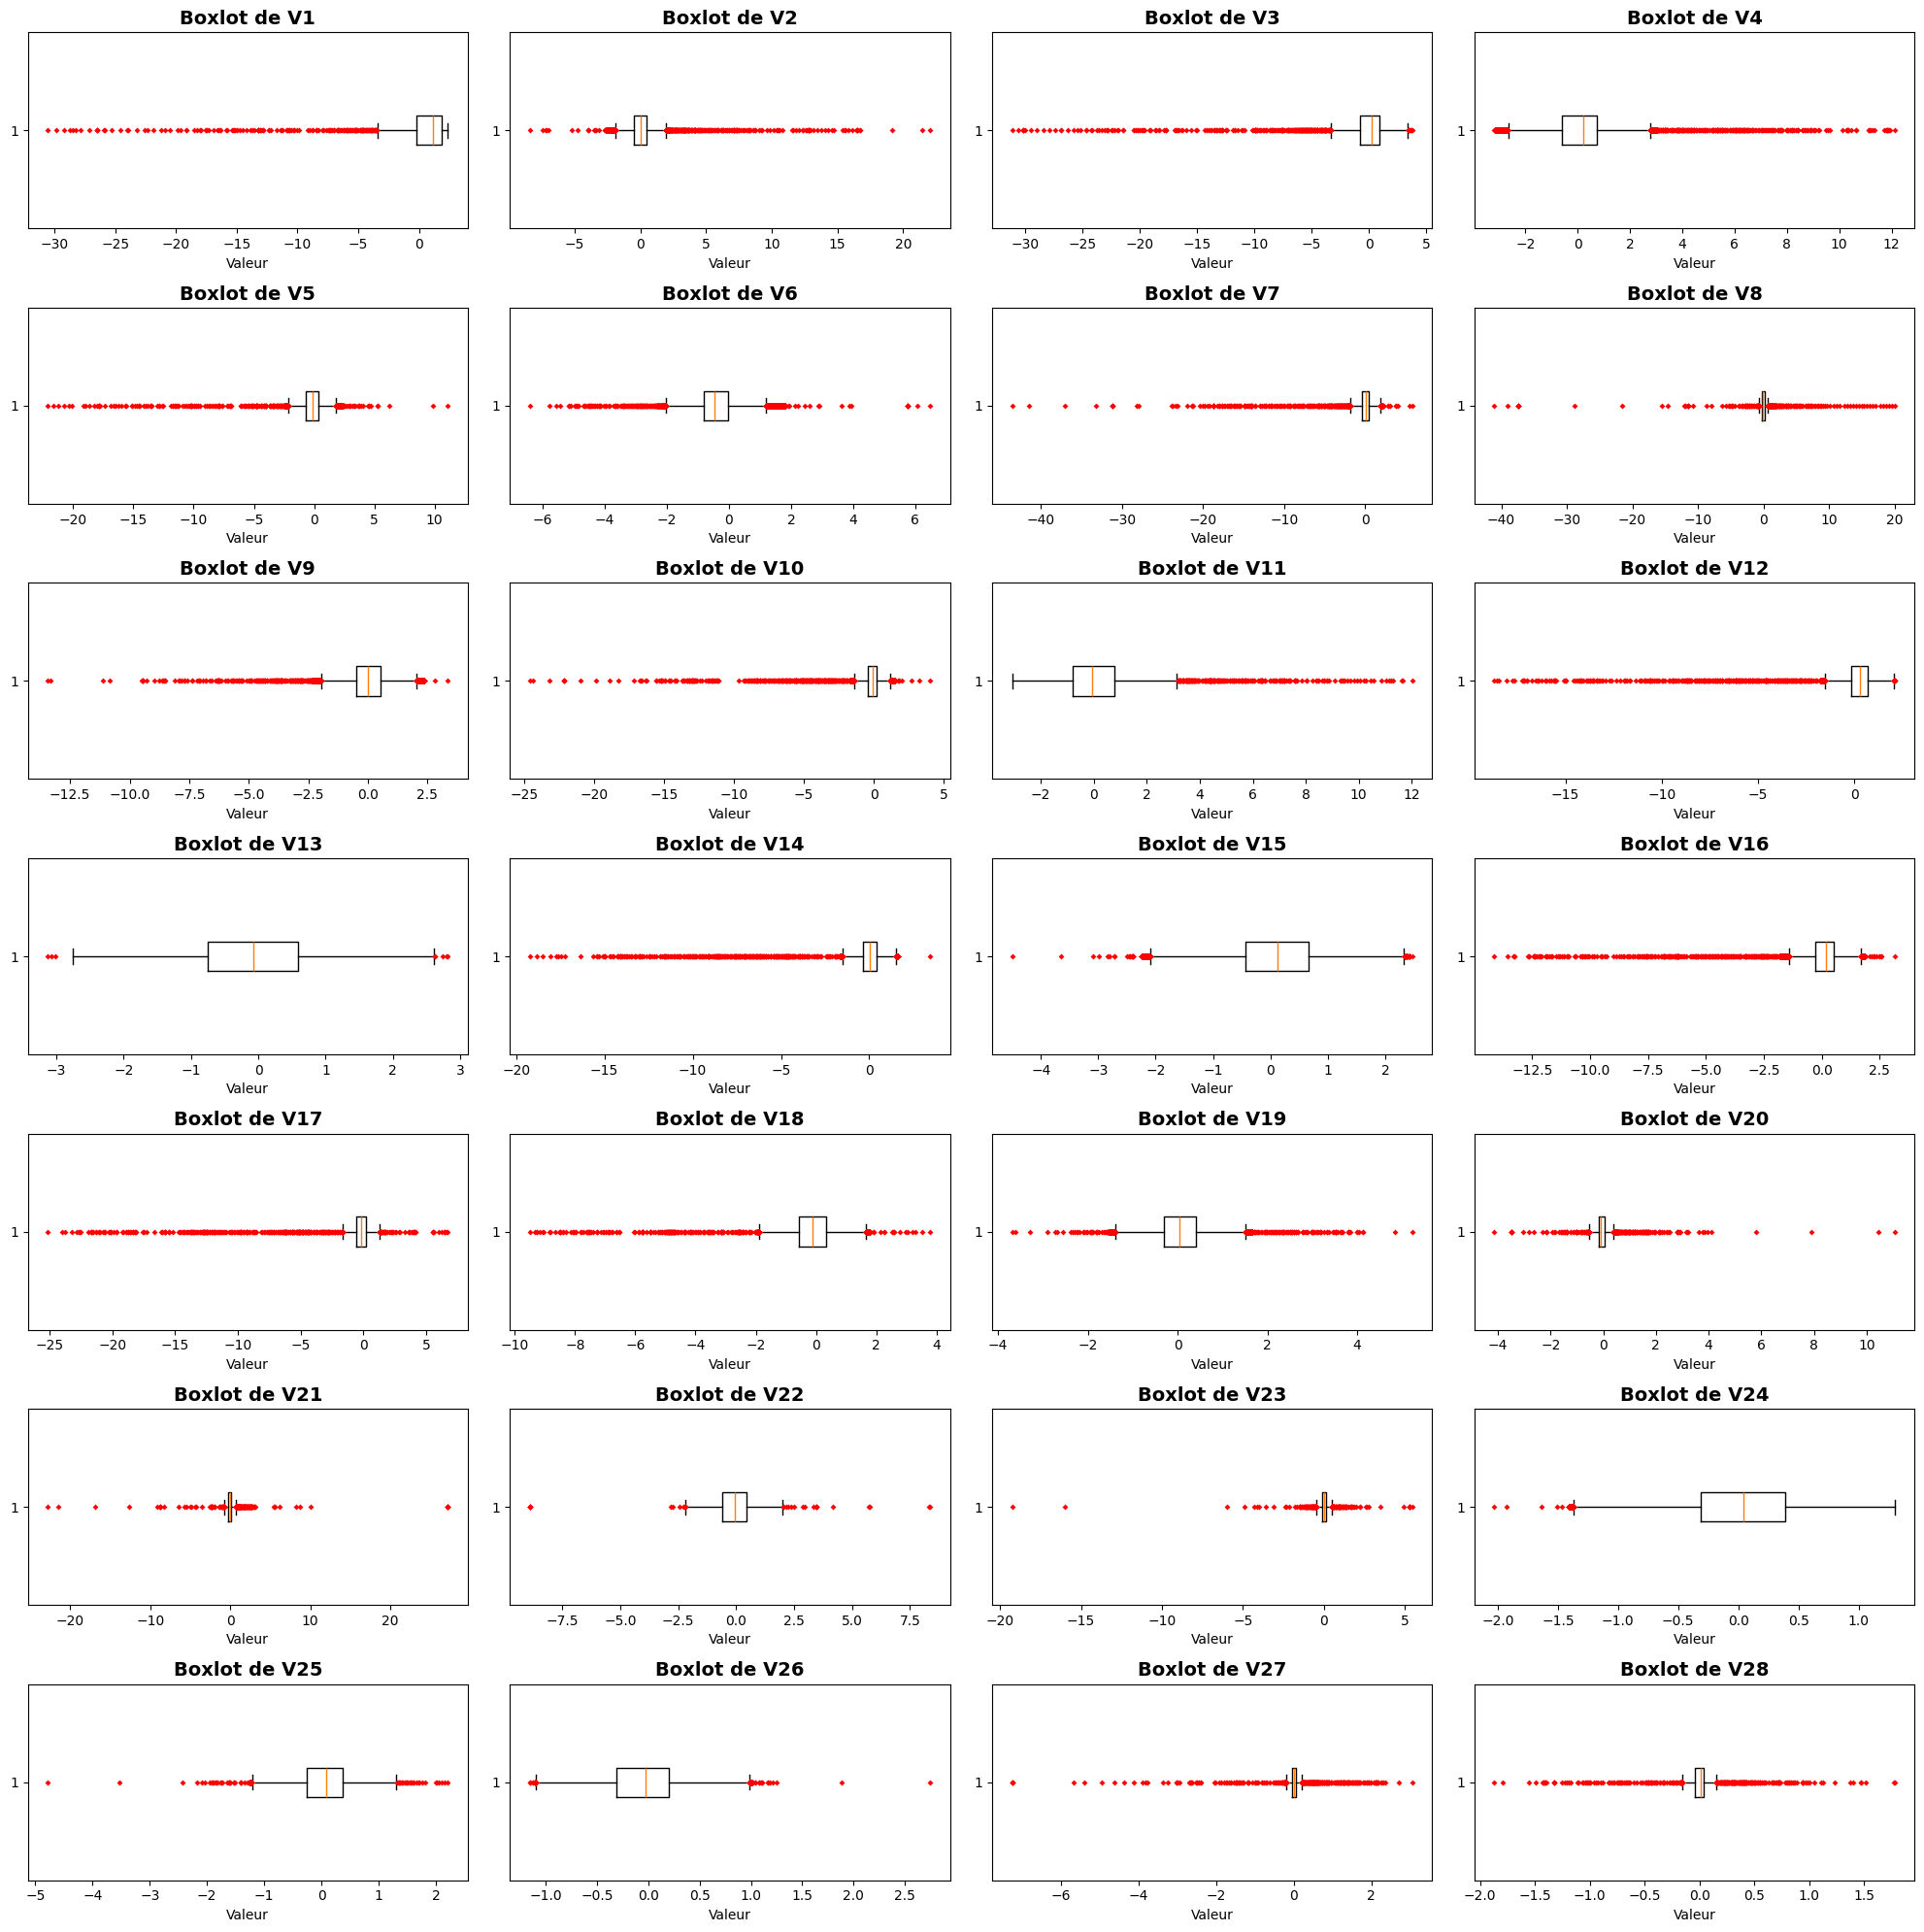

In [72]:
plotBox(dfOutliers,lParameters, row=7, col=4, width=20, height=20)

- Nuage de points et distribution

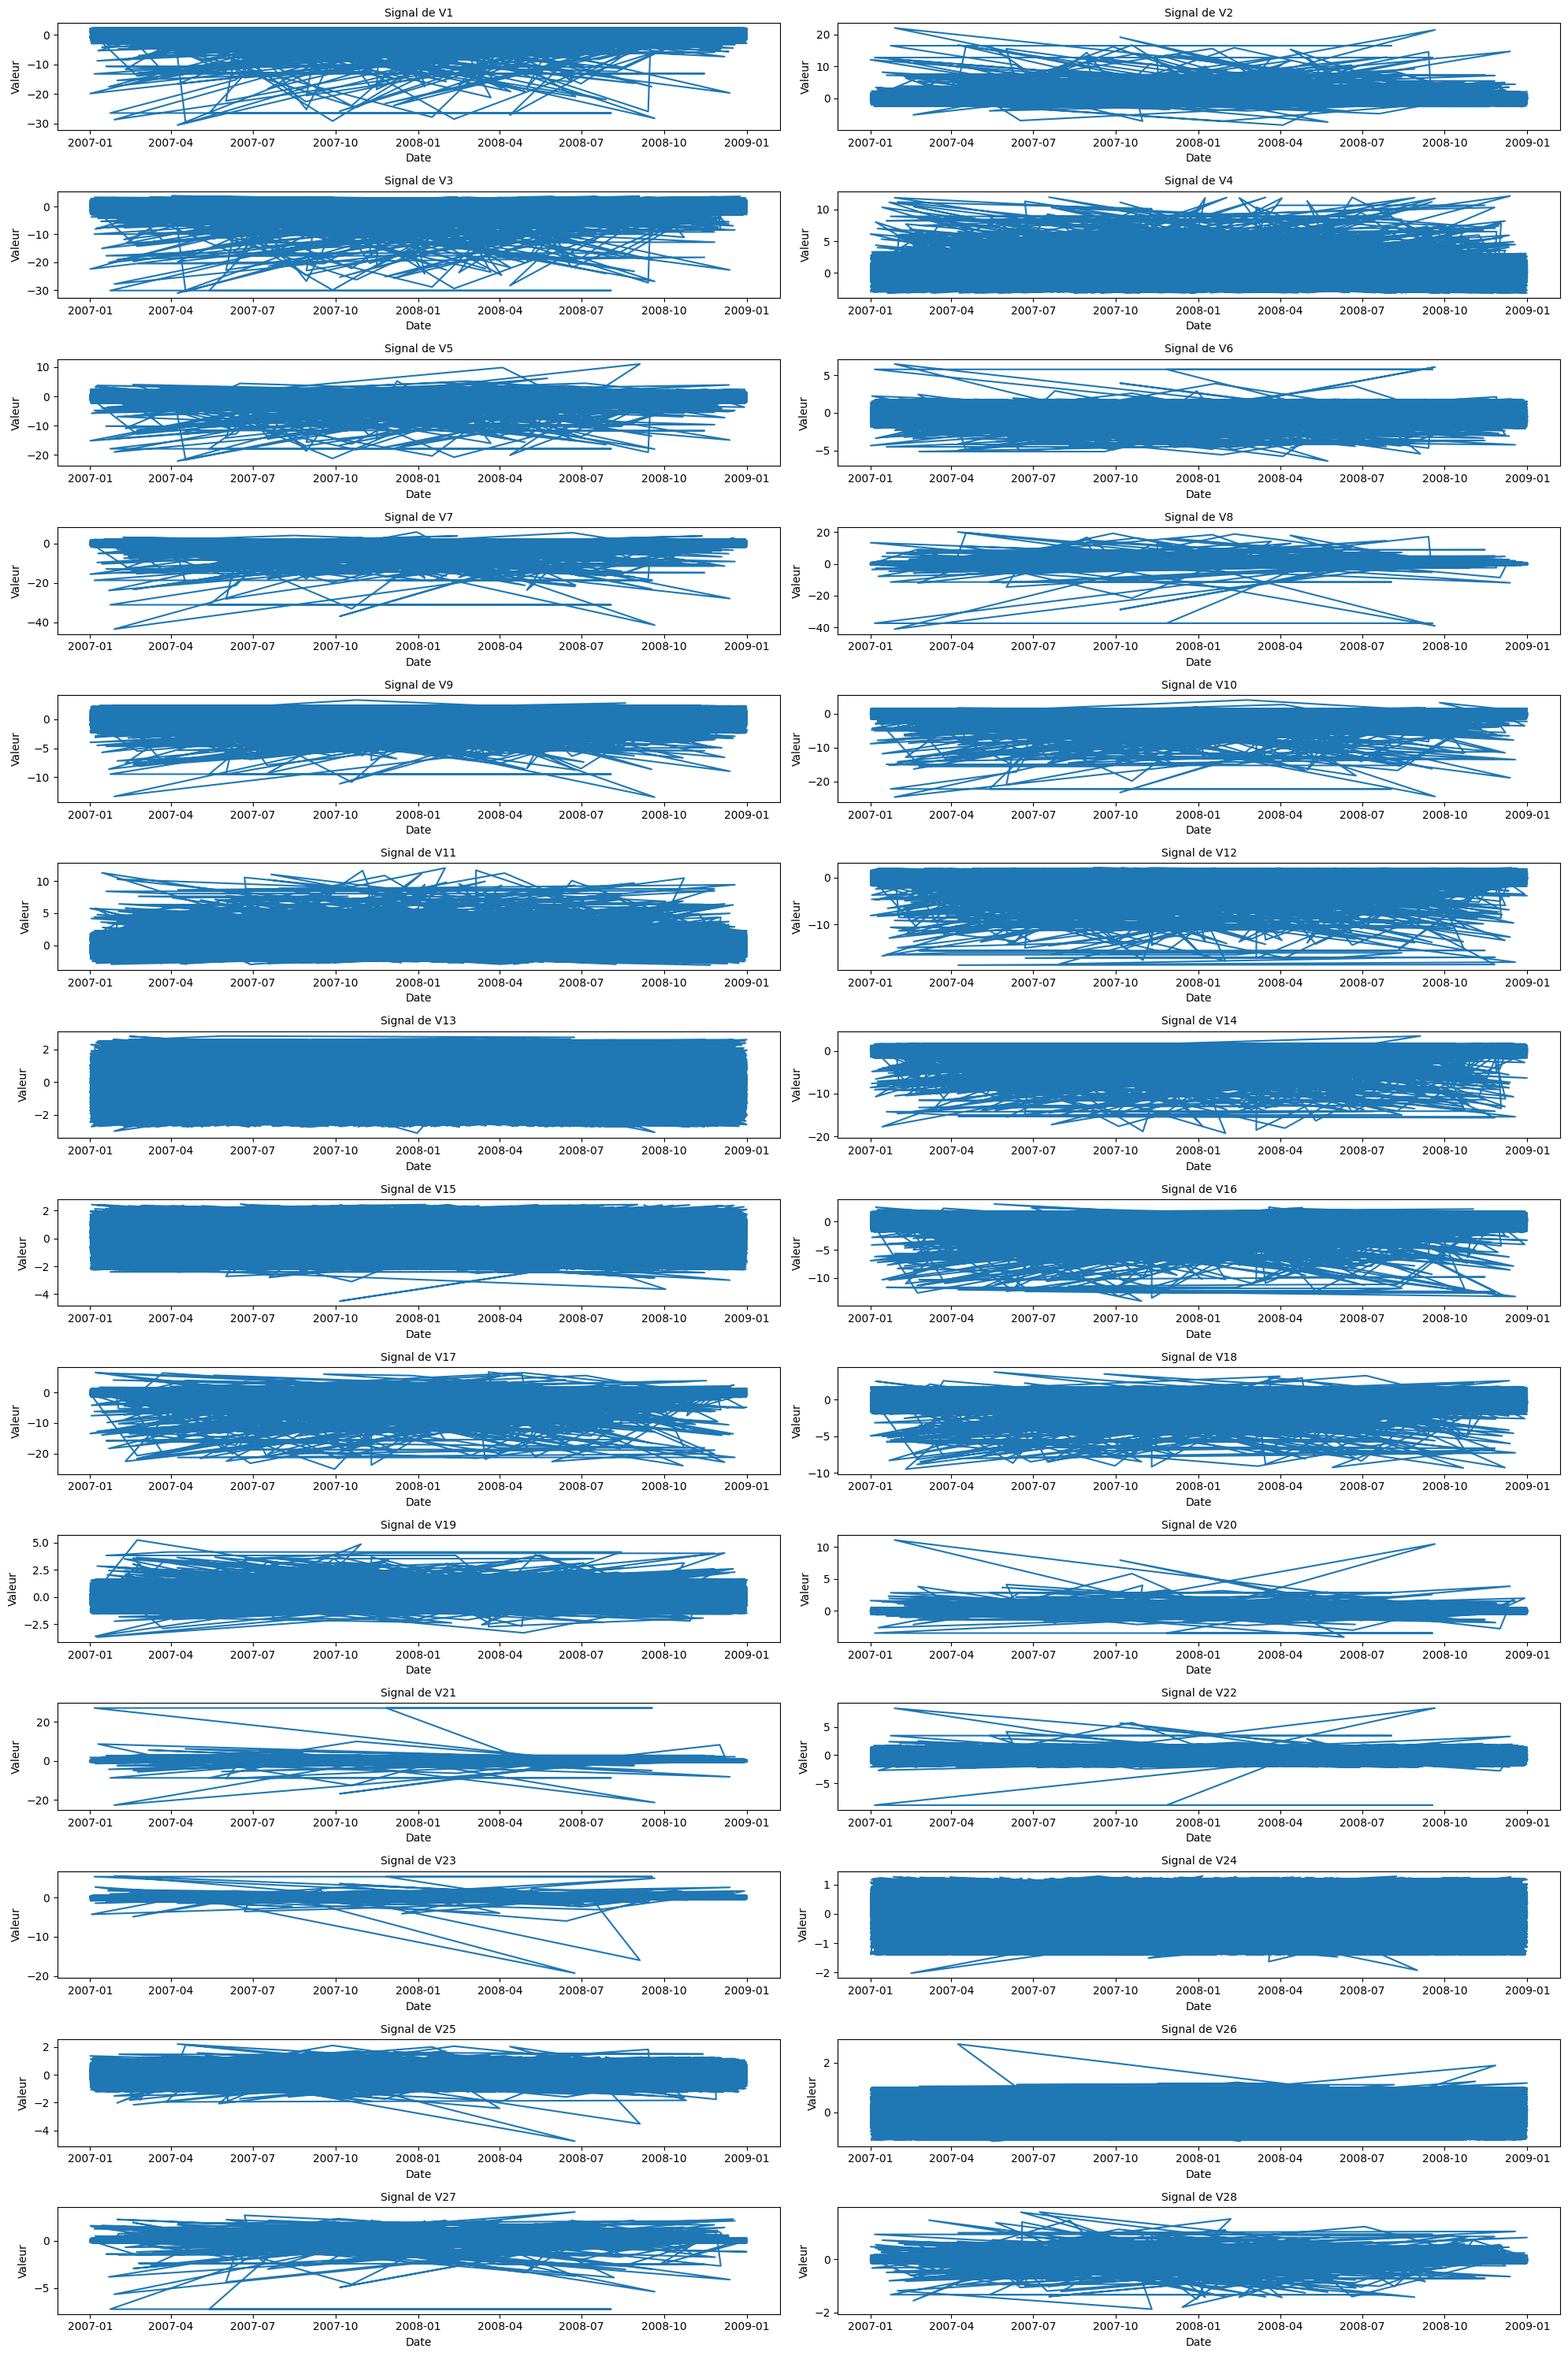

In [73]:
plotSub(dfOutliers, lParameters, row=14, col=2, width=20, height=30)


#### 6. Etapes pour tirer des conclusions sur le relations entre les variables et Class

## Analyse des Distributions des Variables Numériques par Classe

Ces graphiques présentent la distribution de toutes les variables numériques en fonction de la variable cible **`Class`**.

- Chaque graphique montre comment les valeurs d’une variable numérique varient selon les différentes classes.
- Cette comparaison visuelle permet d’identifier rapidement les différences potentielles entre les classes pour chaque variable.
- Les boxplots révèlent la médiane, la dispersion (quartiles), ainsi que la présence éventuelle de valeurs aberrantes (outliers) dans chaque groupe.
- Analyser la distribution de chaque variable par classe est essentiel pour comprendre quelles variables sont discriminantes ou présentent des comportements spécifiques selon la classification.
- Ces informations sont importantes pour la sélection des variables, la détection d’anomalies, et pour orienter la modélisation prédictive.
- Cette exploration visuelle facilite également la phase de machine learning en mettant en évidence les relations entre variables et la variable cible, ce qui peut guider le choix des features et améliorer la performance des modèles.

Cette exploration détaillée facilite une meilleure compréhension des données et appuie la prise de décision dans la phase d’analyse.


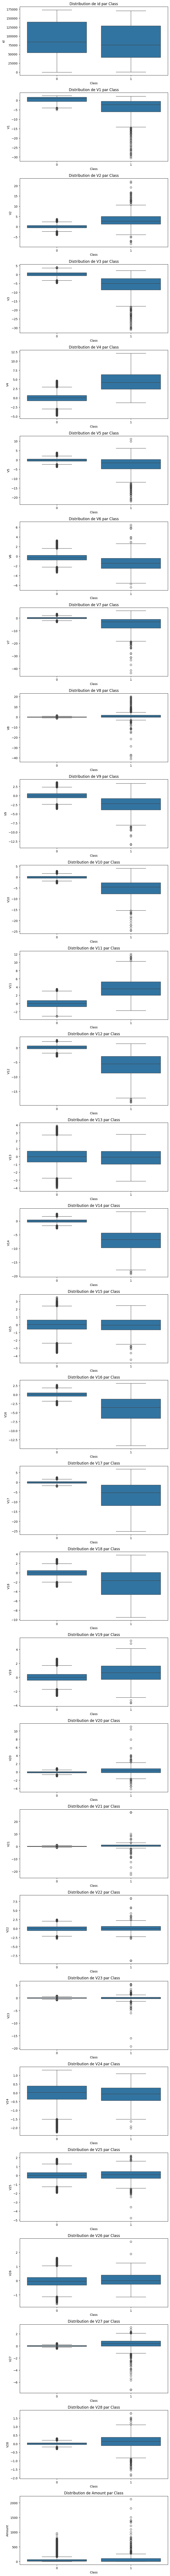

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = dfOutliers.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Class']  # enlever 'Class' si numérique

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Class', y=col, data=dfOutliers, ax=axes[i])
    axes[i].set_title(f'Distribution de {col} par Class')

plt.tight_layout()
plt.show()


## Analyse des Relations entre Variables Numériques et la Classe via Nuages de Points

Ces graphiques en nuages de points illustrent la relation entre chaque variable numérique et la variable cible **`Class`**.

- Chaque graphique montre la dispersion des valeurs d’une variable numérique en fonction de la variable cible.
- La coloration par classe permet de visualiser comment les observations de différentes classes se répartissent dans l’espace des variables.
- Ces nuages de points permettent d’identifier les tendances, corrélations et différences potentielles entre les classes.
- Ils peuvent aussi révéler des regroupements, séparations ou chevauchements entre classes qui sont cruciaux pour la compréhension du problème.
- Cette visualisation est particulièrement utile pour détecter les patterns linéaires ou non-linéaires et pour évaluer la pertinence des variables dans la modélisation.
- En machine learning, ces insights aident à choisir des variables explicatives pertinentes et à concevoir des modèles plus précis et robustes.

Ainsi, ces nuages de points enrichissent l’analyse exploratoire en mettant en lumière les relations clés entre les variables et la classification.


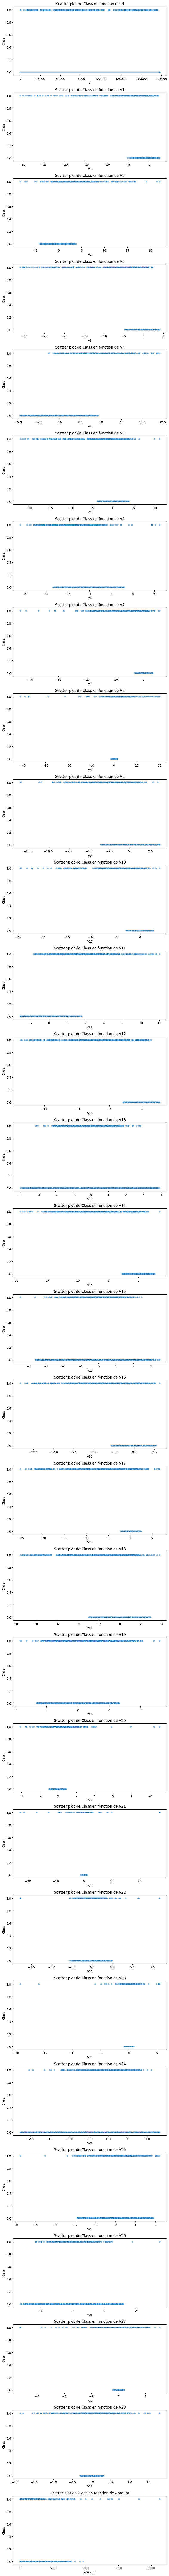

In [58]:

numeric_cols = dfOutliers.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Class']  # On enlève 'Class' pour pas faire x='Class' y='Class'

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(8, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.scatterplot(x=col, y='Class', data=dfOutliers, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Scatter plot de Class en fonction de {col}')

plt.tight_layout()
plt.show()


- L'analyse visuelle nous permet de fixer des bornes à notre échantillon en excluant des points éloignés du nuage de points

- Matrice de des coefficients de corrélation

In [59]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier


### Matrice de Corrélation

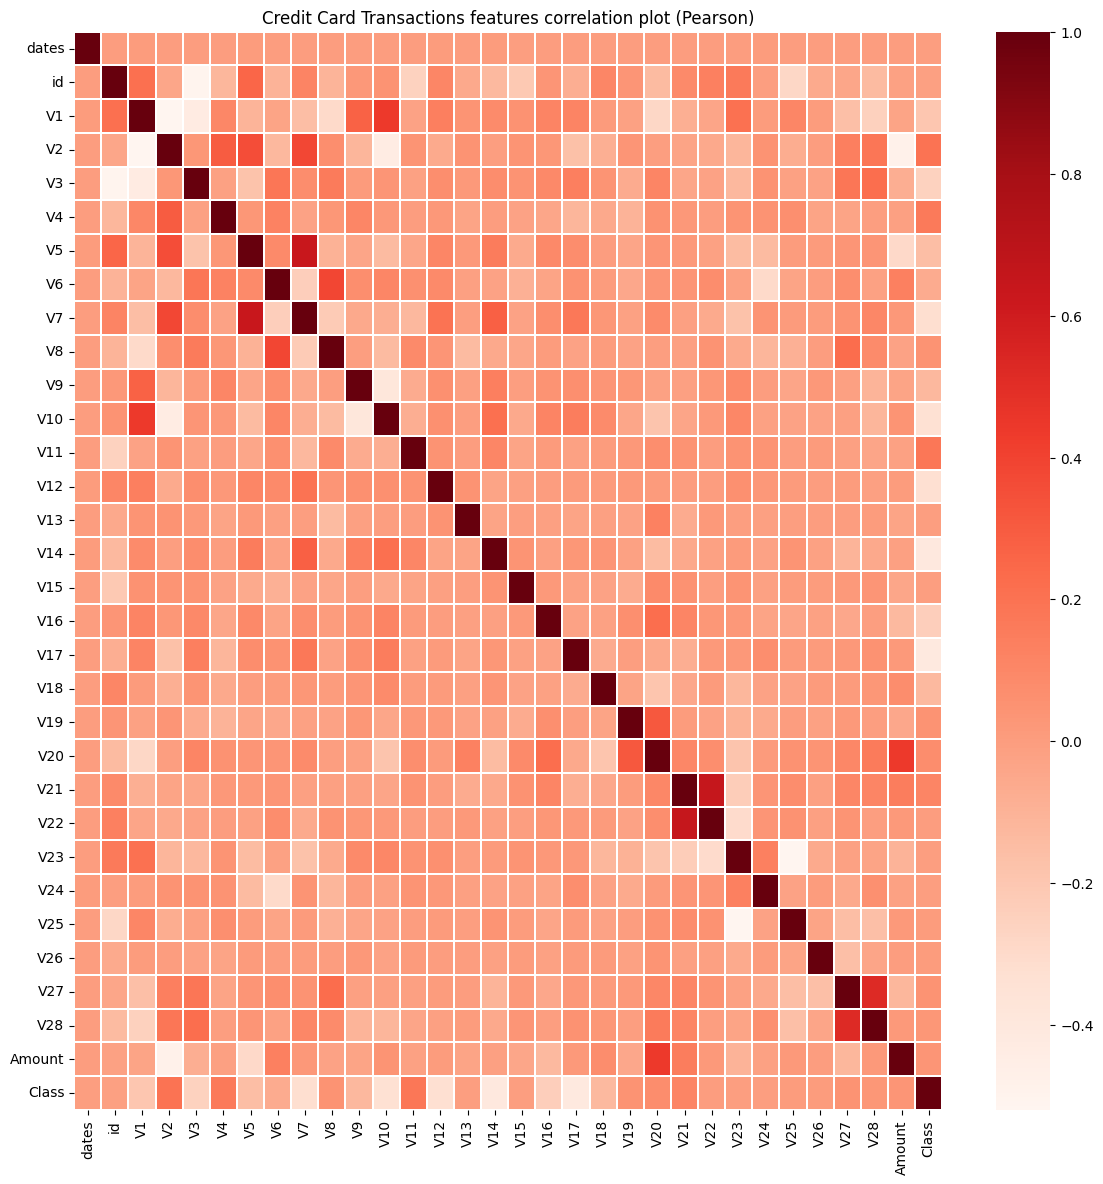

In [60]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = dfOutliers.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

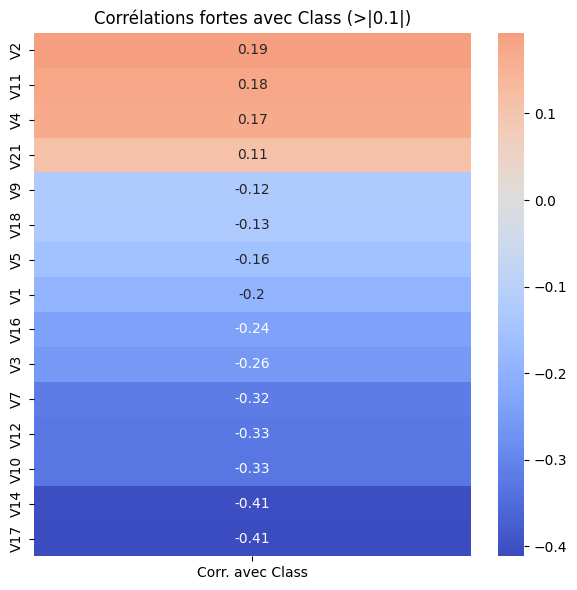

['V2', 'V11', 'V4', 'V21', 'V9', 'V18', 'V5', 'V1', 'V16', 'V3', 'V7', 'V12', 'V10', 'V14', 'V17']


In [61]:
predictors=corrHeatmap(dfOutliers, target_col="Class",threshold=0.1)
print(predictors)

>Dans ce cas features sera la liste ci-dessus retournée par corrheatmap 

#### 7. A-t-on des données manquantes 

- Le dataset ne contient pas de données manquantes

In [62]:
dfWithNan = dataset.isna().sum()
dfWithNan

dates     0
id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### 8. Statistiques descriptives

- Statisiques des variables numériques

In [63]:
dfOutliers.describe().T

count                           mean                  min  \
dates     213630  2008-01-01 17:30:01.639661824  2007-01-01 00:03:44   
id      213630.0                   94924.862735                  0.0   
V1      213630.0                       0.535593            -30.55238   
V2      213630.0                       0.007571            -8.402154   
V3      213630.0                       0.130341           -31.103685   
V4      213630.0                       0.027005            -4.769901   
V5      213630.0                      -0.100937           -22.105532   
V6      213630.0                      -0.219546            -6.406267   
V7      213630.0                       0.002166           -43.557242   
V8      213630.0                       0.063758           -41.044261   
V9      213630.0                      -0.044018           -13.434066   
V10     213630.0                      -0.059986           -24.588262   
V11     213630.0                       0.012619            -3.136813   
V12     213630.0                       0.038701           -18.683715   
V13     213630.0                      -0.011538             -4.00864   
V14     213630.0                       0.005836           -19.214325   
V15     213630.0                      -0.016499            -4.498945   
V16     213630.0                       0.000909           -14.129855   
V17     213630.0                      -0.055468           -25.162799   
V18     213630.0                      -0.022844            -9.498746   
V19     213630.0                      -0.005959            -3.681904   
V20     213630.0                      -0.050793            -4.128186   
V21     213630.0                      -0.019058           -22.797604   
V22     213630.0                      -0.004159            -8.887017   
V23     213630.0                      -0.004401           -19.254328   
V24     213630.0                      -0.031581            -2.257481   
V25     213630.0                       0.009906            -4.781606   
V26     213630.0                      -0.000214            -1.641329   
V27     213630.0                       0.018458            -7.263482   
V28     213630.0                       0.012914             -1.86929   
Amount  213630.0                      56.288834                  0.0   
Class   213630.0                       0.002303                  0.0   

                               25%                         50%  \
dates   2007-07-02 22:45:30.500000  2008-01-01 11:15:56.500000   
id                         54322.0                     83993.5   
V1                        -0.57073                    1.027236   
V2                       -0.547333                    0.018626   
V3                       -0.698159                    0.274193   
V4                       -0.771408                    0.055948   
V5                        -0.68289                   -0.121438   
V6                       -0.779597                   -0.345892   
V7                       -0.494284                    0.040298   
V8                        -0.17407                    0.016668   
V9                       -0.632491                   -0.062439   
V10                      -0.503433                   -0.105605   
V11                      -0.776356                     0.00414   
V12                      -0.369403                    0.167831   
V13                      -0.695004                   -0.013355   
V14                      -0.392069                    0.047959   
V15                       -0.57737                    0.032622   
V16                      -0.440444                    0.071704   
V17                      -0.485507                   -0.092605   
V18                      -0.509157                    -0.02818   
V19                      -0.420288                    0.011296   
V20                      -0.201736                   -0.078081   
V21                      -0.215888                   -0.032962   
V22                      -0.543551                

- Statisiques des variables catégorielles

- On constate un déséquilibre marqué entre les classes : la classe 1 contient peu de données comparée à la classe 0.

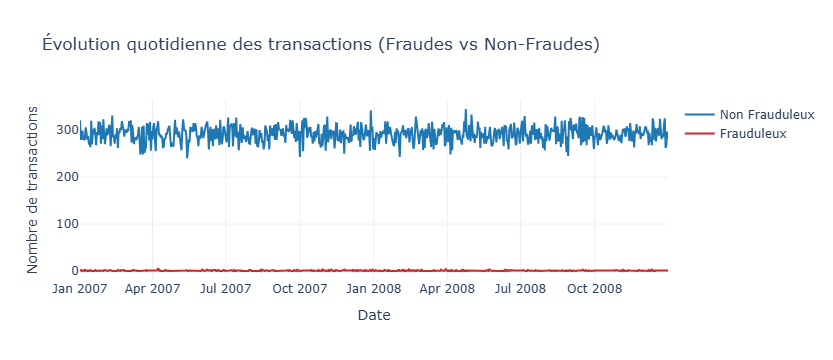

In [65]:
# Grouper par date (par jour, mois ou semaine selon ton besoin)
df_daily = dfOutliers.groupby([dataset['dates'].dt.to_period('D'), 'Class']).size().unstack(fill_value=0)
df_daily.index = df_daily.index.to_timestamp()

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily[0], mode='lines', name='Non Frauduleux', line=dict(color='#1f77b4')))
fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily[1], mode='lines', name='Frauduleux', line=dict(color='#d62728')))

fig.update_layout(
    title="Évolution quotidienne des transactions (Fraudes vs Non-Fraudes)",
    xaxis_title="Date",
    yaxis_title="Nombre de transactions",
    template="plotly_white"
)
fig.show()


#### 9. Sauvegarde des résultats

In [66]:
dfOutliers.to_csv(f"cleanedData.csv", sep=sep, encoding=encodage, index=False, header=True)